# Exercise 6: Clustering

In this assignment you will experiment with k-means as an image compression algorithm.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw6_123456789_987654321.ipynb` if you submitted in pairs and `hw6_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## Part 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [247]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

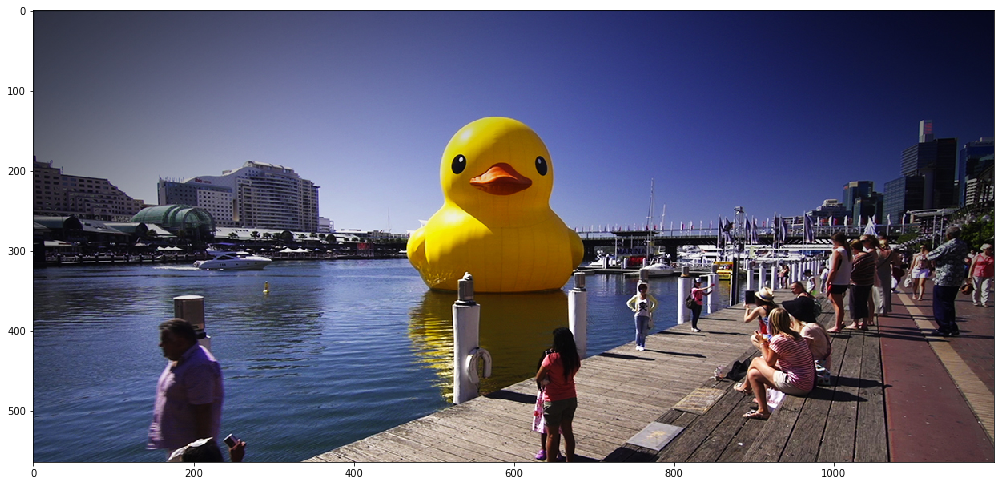

(564, 1200, 3)


In [248]:
# load the image and confirm skimage is imported properly.
image = io.imread('data/small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [249]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)

(676800, 3)


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [250]:
def get_random_centroids(X, k):
    centroids = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    random_centroid = np.random.randint(X.shape[0], size = k)
    centroids = X[random_centroid, :]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids

In [251]:
k = 7 
centroids = get_random_centroids(image, k)
print(centroids)

[[ 71  94 144]
 [ 94  97 112]
 [ 88 102 177]
 [ 12  13  18]
 [ 58  58  70]
 [216 196 185]
 [ 62  71 146]]


## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [252]:
def lp_distance(X, centroids, p=2):
    distances = []
    for c in centroids:
        lp = np.power(np.sum(np.power(np.abs(X - c), p), axis=1), (1 / p))
        distances.append(lp)
    return np.array(distances)

In [253]:
distances = lp_distance(image, centroids, 5)
print(distances)
print(distances.shape)
print(distances.mean())

[[3.25252225 1.58489319 3.32923661 ... 3.0073711  2.84382317 3.28407202]
 [3.00246508 0.         3.53370523 ... 0.         3.31445402 3.11226501]
 [3.03143313 3.49569957 2.69056707 ... 3.25608862 2.90250812 3.07291192]
 ...
 [2.80936139 3.00981215 3.67464137 ... 3.1517523  3.21409585 3.40988855]
 [2.49146188 2.87376476 2.98503666 ... 2.78651802 2.49146188 3.14564815]
 [3.05933446 3.28750366 3.10153281 ... 2.86193816 2.15056001 3.31776186]]
(7, 676800)
2.9828666643761963


## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops, 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than a minute with `k=16`.

In [254]:
# given the instances and their distances from each centroid,
# returns the class mapping for each instance
def sort_to_clusters(X, distances, k):
    clusters = []
    cluster_mapping = np.argmin(distances, axis=0)
    for i in range(k):
        class_i = X[cluster_mapping == i, :]
        clusters.append(class_i)
    return clusters

In [255]:
# calculate the mean of each class
def calculate_new_centroids_means(classes_list):
    new_centroids = []
    for cls in classes_list:
        new_centroids.append(np.mean(cls, axis=0))
    return np.array(new_centroids)

In [256]:
# calculate the median of each class
def calculate_new_centroids_median(classes_list):
    new_centroids = []
    for cls in classes_list:
        new_centroids.append(np.median(cls, axis=0))
    return np.array(new_centroids)

In [257]:
# calculate the total MSE of the current clusters
def calculate_improvement(classes_list, centroids):
    imp = 0
    for i in range(centroids.shape[0]):
        imp += np.square(np.linalg.norm(classes_list[i] - centroids[i]))
    return imp

In [258]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = []
    best_classes = []
    centroids = get_random_centroids(X, k)
    imp = np.Inf
    
    for i in range(max_iter):
        distances = lp_distance(X, centroids, p)
        classes = sort_to_clusters(X, distances, k)
        centroids = calculate_new_centroids_means(classes)
        new_imp = calculate_improvement(classes, centroids)
        
        # stop the loop if we got no improvement in the total error
        if (imp <= new_imp):
            break
        else:
            imp = new_imp
            best_classes = classes
            best_classes_mapping = np.argmin(distances, axis=0)
            
    return centroids, best_classes_mapping

In [259]:
centroids, classes = kmeans(image, k=4, p=1, max_iter=100)

In [260]:
def kmedian(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    classes = []
    best_classes = []
    centroids = get_random_centroids(X, k)
    imp = np.Inf
    
    for i in range(max_iter):
        distances = lp_distance(X, centroids, p)
        classes = sort_to_clusters(X, distances, k)
        centroids = calculate_new_centroids_median(classes)
        new_imp = calculate_improvement(classes, centroids)
        
        # stop the loop if we got no improvement in the total error
        if (imp <= new_imp):
            break
        else:
            imp = new_imp
            best_classes = classes
            best_classes_mapping = np.argmin(distances, axis=0)
            
    return centroids, best_classes_mapping

In [261]:
centroids, classes = kmedian(image, k=4, p=1, max_iter=100)

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

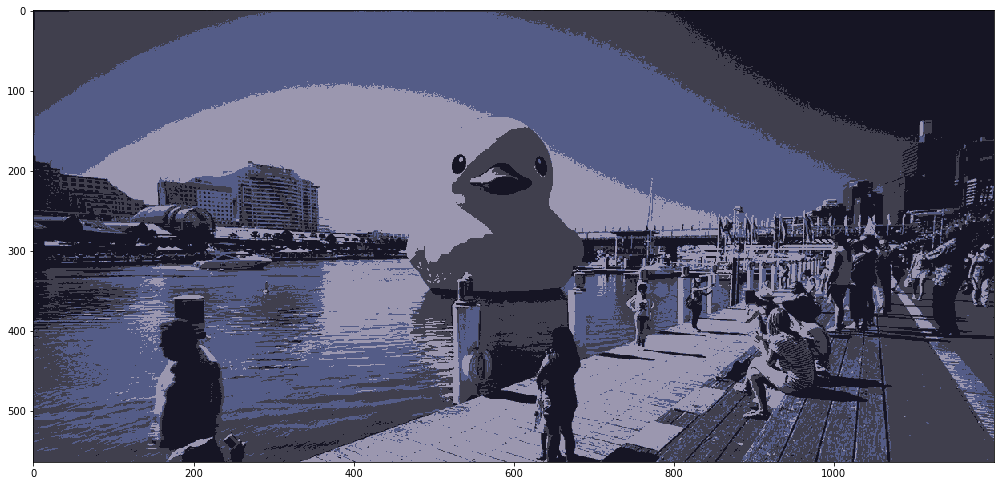

In [262]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## Hyper parameter tuning (20 points)

Run the algorithm for each of the following values for `p = [1,2,3,4,5]` . Test multiple values for `k=[4,8,16]` using two different cluster calculation criteria: the mean and the median of the cluser. For each test, calculate the intertia and visualize it using graphs. Explain you results.

In [263]:
def compressed_image(classes, rows, cols ,centroids):
    classes = classes.reshape(rows,cols) 
    compressed_image = np.zeros((classes.shape[0],classes.shape[1],3),dtype=np.uint8 )
    for i in range(classes.shape[0]):
        for j in range(classes.shape[1]):
                compressed_image[i,j,:] = centroids[classes[i,j],:]
    io.imshow(compressed_image)
    io.show()
    return

Image Compressing with k = 4 clusters and p = 1


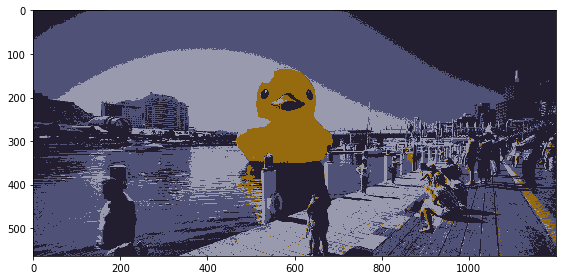

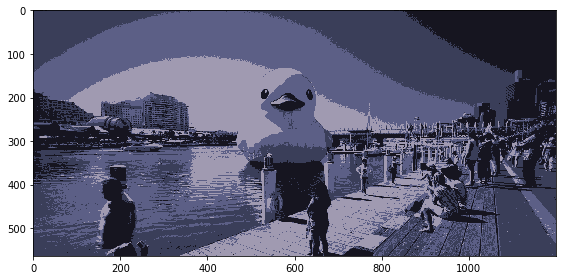

Image Compressing with k = 8 clusters and p = 1


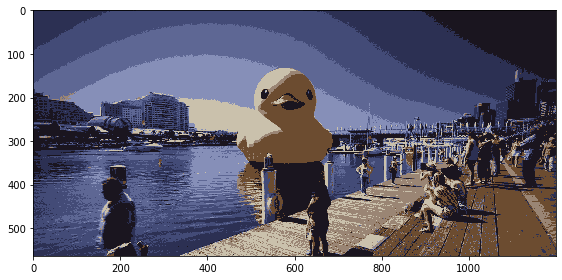

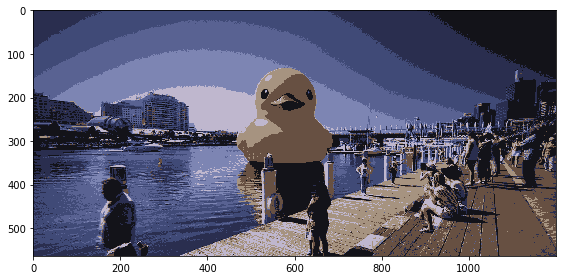

Image Compressing with k = 16 clusters and p = 1


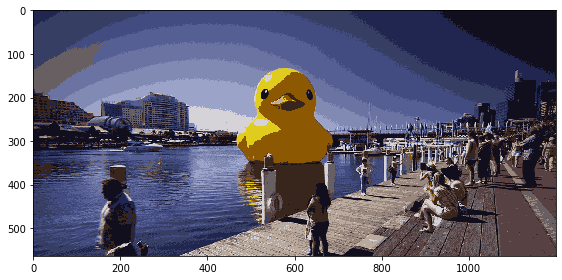

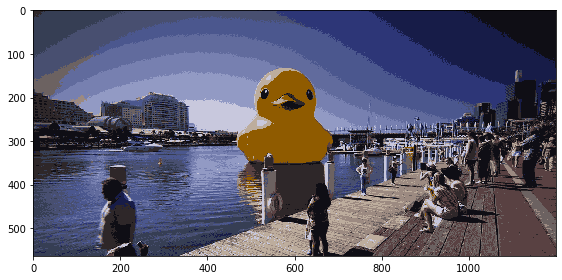

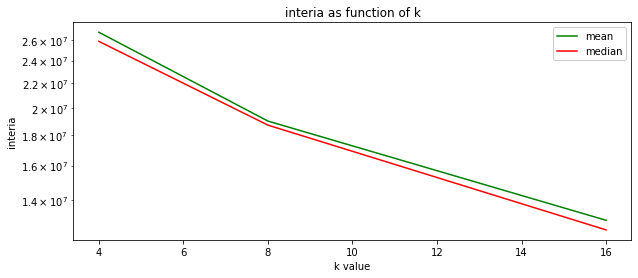

Image Compressing with k = 4 clusters and p = 2


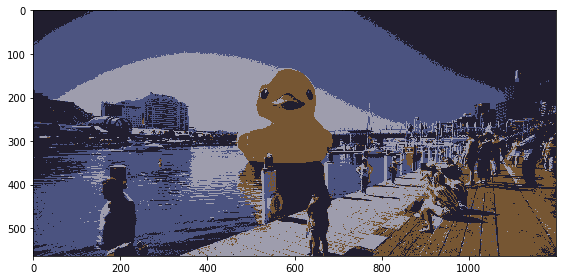

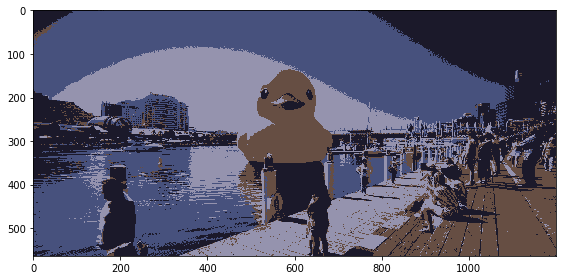

Image Compressing with k = 8 clusters and p = 2


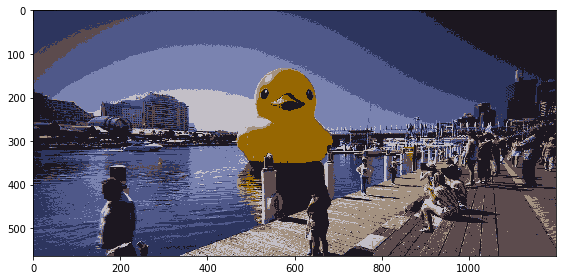

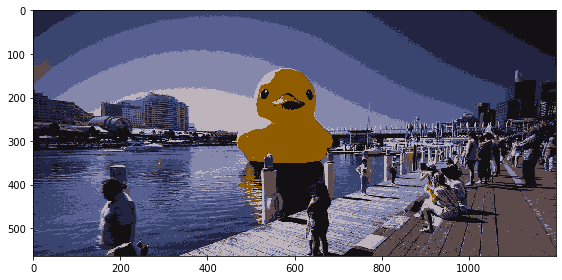

Image Compressing with k = 16 clusters and p = 2


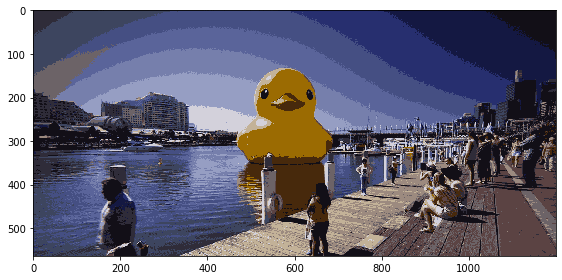

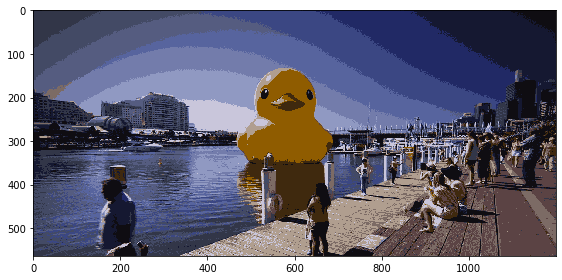

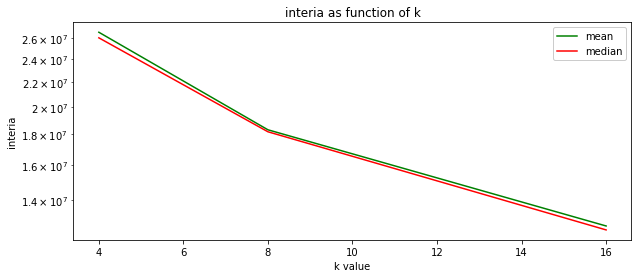

Image Compressing with k = 4 clusters and p = 3


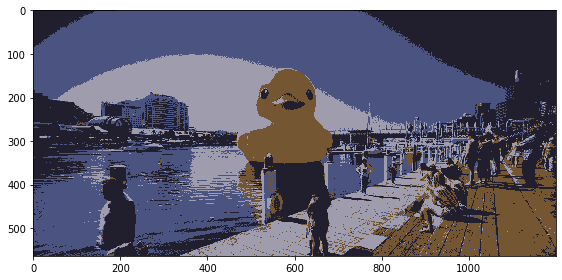

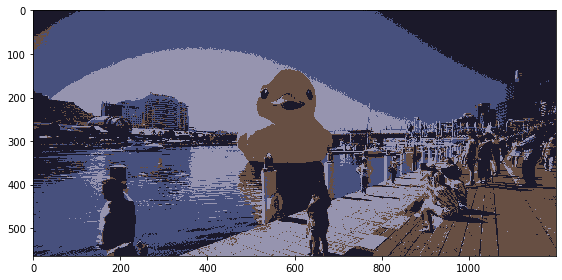

Image Compressing with k = 8 clusters and p = 3


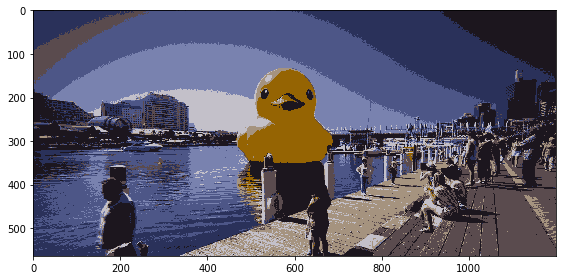

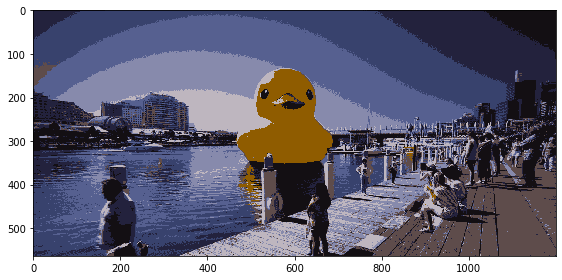

Image Compressing with k = 16 clusters and p = 3


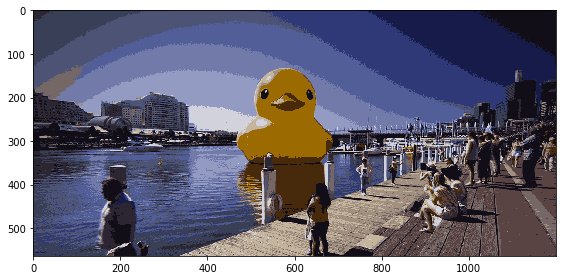

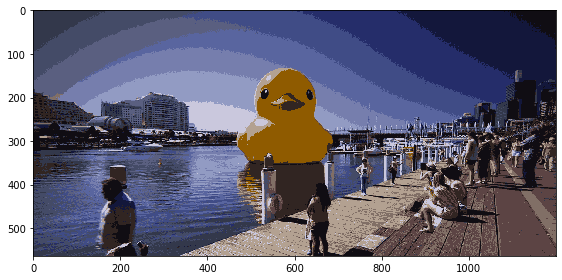

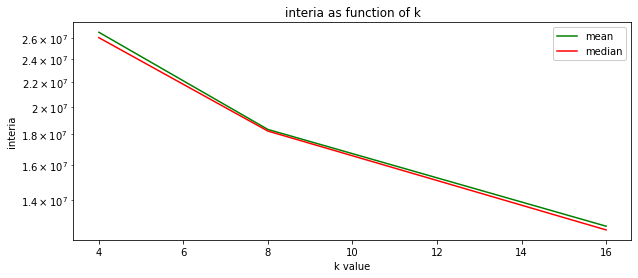

Image Compressing with k = 4 clusters and p = 4


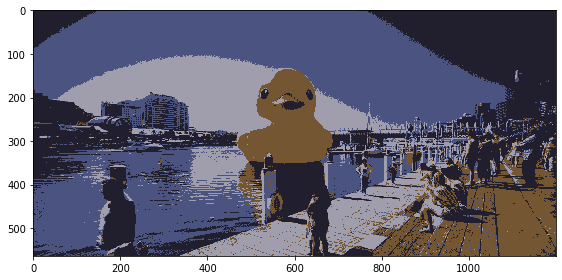

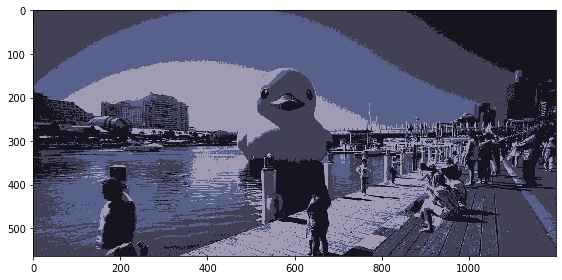

Image Compressing with k = 8 clusters and p = 4


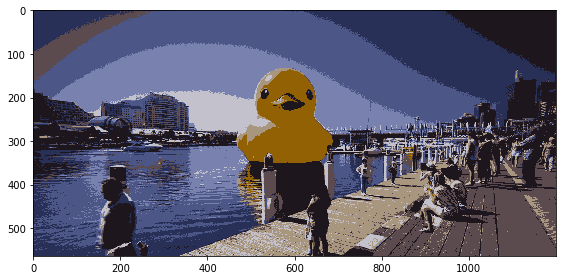

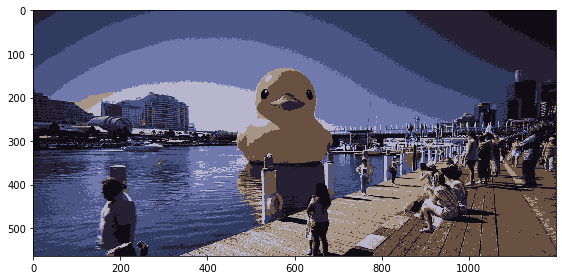

Image Compressing with k = 16 clusters and p = 4


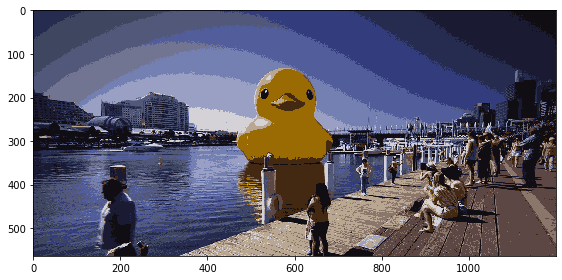

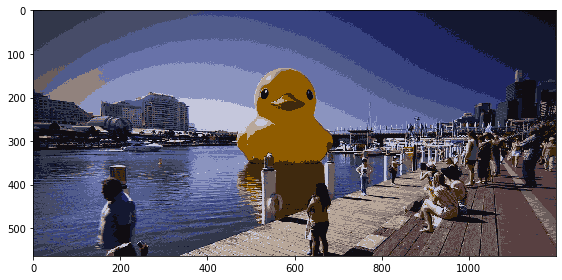

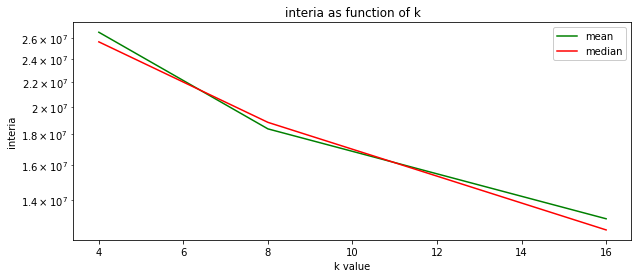

Image Compressing with k = 4 clusters and p = 5


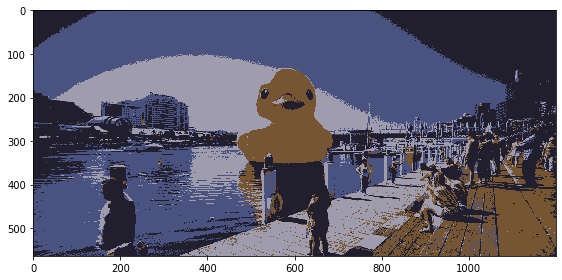

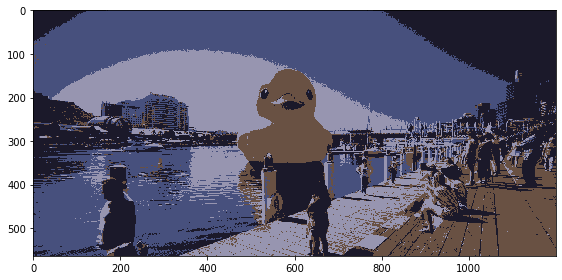

Image Compressing with k = 8 clusters and p = 5


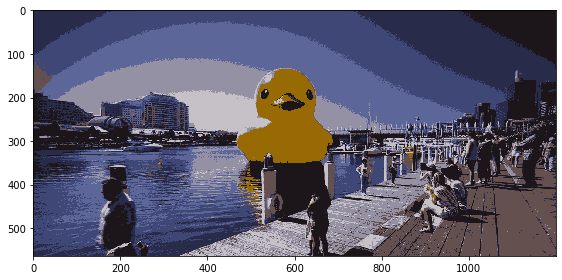

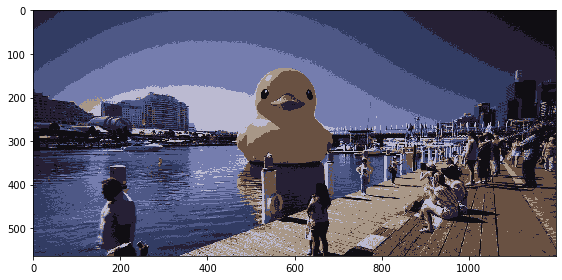

Image Compressing with k = 16 clusters and p = 5


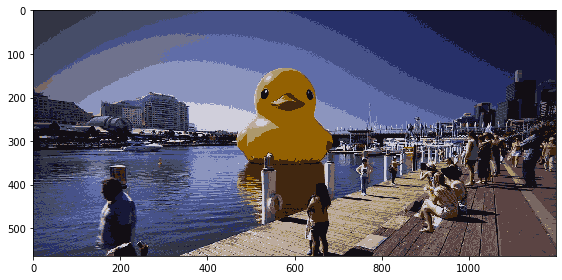

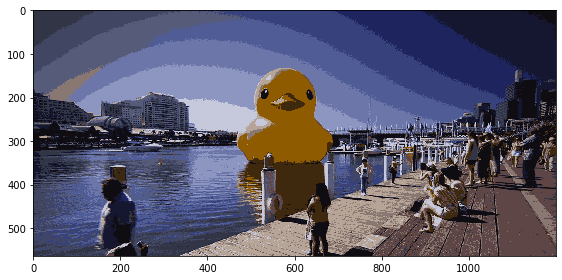

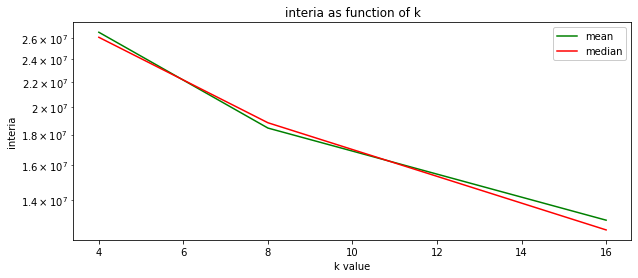

In [267]:
p_values = [1, 2, 3, 4, 5]
k_values = [4, 8, 16]
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots
for pv in p_values:
    np.random.seed(8765)
    classes_p_mean = []
    centroids_p_mean = []
    counts_mean=[]
    sum_dis_mean = []
    classes_p_median = []
    centroids_p_median = []
    counts_median=[]
    sum_dis_median = []
    for kv in k_values:
        print("Image Compressing with k = %s clusters and p = %s" % (kv, pv))
        cent_mean, cla_mean = kmeans(image, k= kv, p=pv, max_iter=100)
        cent_median, cla_median = kmedian(image, k= kv, p=pv, max_iter=100)
        c_mean, count_mean = np.unique(cla_mean, return_counts=True)
        c_median, count_median = np.unique(cla_median, return_counts=True)
        dis_mean = lp_distance(image, cent_mean, p=2)
        dis_median = lp_distance(image, cent_median, p=2)
        sum_dis_mean.append(np.sum(dis_mean.min(axis=0)))
        sum_dis_median.append(np.sum(dis_median.min(axis=0)))
        compressed_image(cla_mean,rows,cols,cent_mean)
        compressed_image(cla_median,rows,cols,cent_median)
        classes_p_mean.append(cla_mean)
        classes_p_median.append(cla_median)
        centroids_p_mean.append(cent_mean)
        centroids_p_median.append(cent_median)
        counts_mean.append(count_mean)
        counts_median.append(count_median)
    plt.plot(k_values, sum_dis_mean, color='green', label='mean')
    plt.plot(k_values, sum_dis_median, color='red', label='median')
    plt.title("interia as function of k")
    plt.ylabel("interia") #sum of distances of points from thier centroid   
    plt.xlabel("k value")
    plt.yscale('log')
    plt.legend(framealpha=1, frameon=True)
    plt.show()

Inertia is the amount of closeness between all the points in a specific cluser. We can see that with fixed values of k is unclear if a larger p will lead to a better improvement. 
Also in all the graphs there is not a big change when updating the centriods with mean or median. That means that the median value close to the mean value in this picture --> the points in a cluster are spread. 
However, we also can see that for small value of k (less clusters) there is more change between the mean amd the median. The median pictures have a rule color (the color that the most of the picture has) blue, unlike the mean pictures that even with a small k, there is still a yellow color cluster.